In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy
import statsmodels.stats.api as sms
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_white
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.arima import auto_arima

The project aims to analyse credit liabilities of Canadian households from 2021 to 2023, specifically non-mortgage loans and credit card usage. The data has been sourced from the <a href="https://www.statcan.gc.ca/fr/debut">Statistique Canada</a> portal, which provides information on various aspects of life in Canada. The following sections will address:
<ul>
     <li>Overview of the problem</li>
     <li>Time series decomposition</li>
     <li>Selecting the initial model</li>
     <li>Residuals analysis</li>
     <li>Choosing the second model</li>
     <li>Models comparision</li>
     <li>Forecasting</li>

## Overview of the problem

In [2]:
kanada = pd.read_csv("kanada.csv")
kanada.Date = kanada.Date.astype('datetime64[ns]')

kredyty_nieh = kanada[kanada['Credit liabilities of households'] == "Non-mortgage loans"].drop('Credit liabilities of households', axis=1)
kredyty_nieh['Date'] = pd.to_datetime(kredyty_nieh['Date']) 
#

karta_kred = kanada[kanada['Credit liabilities of households'] == "Credit cards"].drop('Credit liabilities of households', axis=1)
karta_kred['Date'] = pd.to_datetime(karta_kred['Date'])  
karta_kred = karta_kred.set_index('Date')

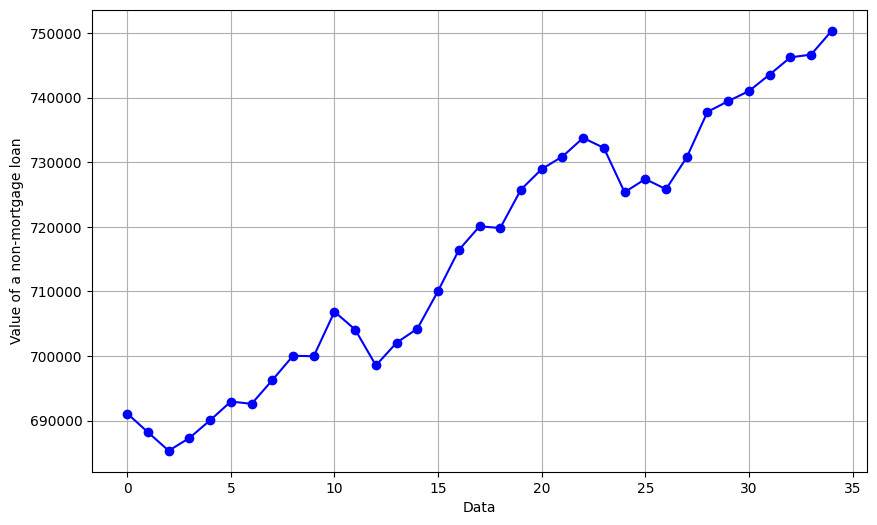

In [3]:
#| label: fig-overview
#| fig-cap: Distribution of non-mortgage loans taken out on average

plt.figure(figsize=(10, 6))
plt.plot(kredyty_nieh.index, kredyty_nieh['VALUE'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Value of a non-mortgage loan')
plt.grid(True)
plt.show()

The above chart (refer to @fig-overview) illustrates that Canadians' non-mortgage loan commitments to banks increased steadily over the months.
Assuming an average loan of CAD 690,000 in January 2021, it has now risen to approximately CAD 750,000 by the end of the review period in December 2023. This indicates an average percentage increase in household debt in Canada over the stated period is approximately:

In [4]:
str(round(750000/690000 * 100 - 100, 2)) + "%"

'8.7%'

The figure presented in @fig-boxplot1 clearly shows the growth of banking liabilities for the average household in Canada from 2021 to 2023.

In [5]:
a = kredyty_nieh.copy()
a["year"] = a.Date.dt.year
a["month"] = a.Date.dt.month

<Figure size 1200x600 with 0 Axes>

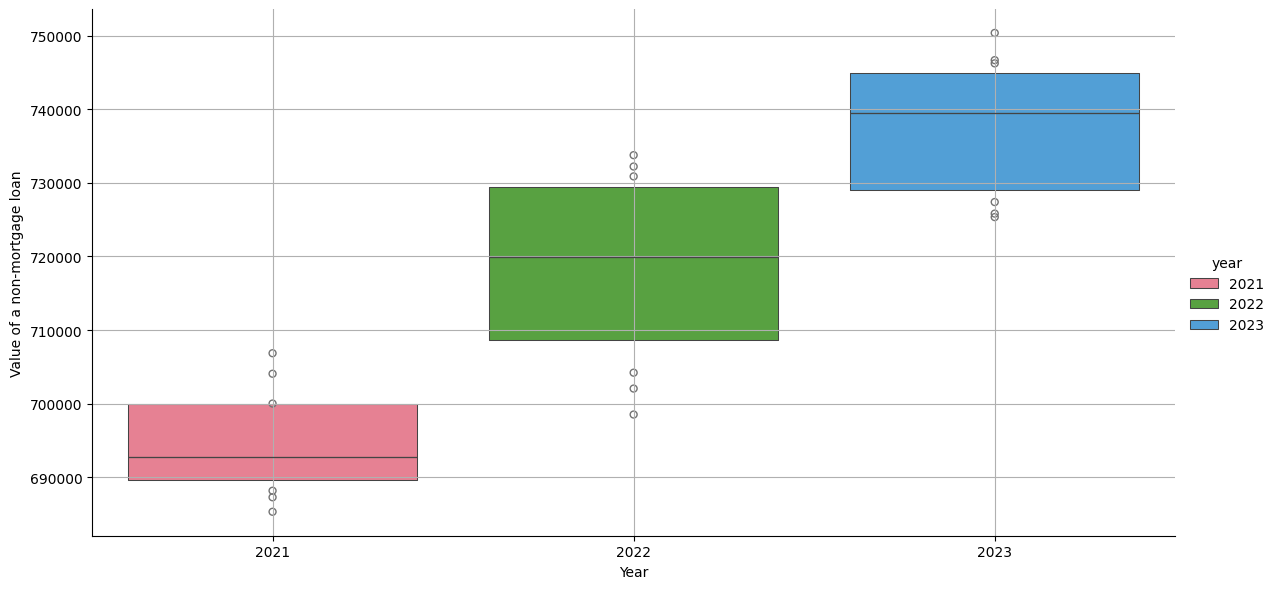

In [6]:
#| label: fig-boxplot1
#| fig-cap: Box plot showing the distribution of non-mortgage loans held by year

custom_palette = sns.color_palette("husl", 3) 

plt.figure(figsize=(12, 6))
sns.catplot(data=a, x="year", y="VALUE", hue="year", kind="boxen", palette=custom_palette, height=6, aspect=2)
plt.xlabel('Year')
plt.ylabel('Value of a non-mortgage loan')
plt.grid(True)
plt.show()

Let's examine the performance of demand for non-mortgage loans on a monthly basis:

C:\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


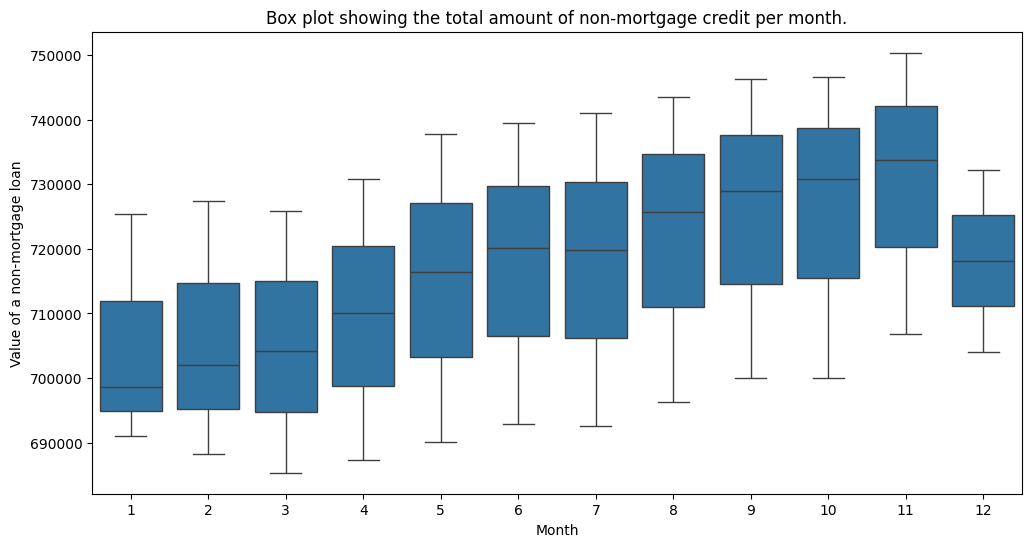

In [7]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='VALUE', data=a)
plt.title('Box plot showing the total amount of non-mortgage credit per month.')
plt.xlabel('Month')
plt.ylabel('Value of a non-mortgage loan')
plt.show()

Throughout the year, larger loans are increasingly taken out on average, except for December when the average loan amount deviates from the trend and is significantly lower than the previous month. Although it may appear that the highest lending of the year would occur during the Christmas period, particularly in the Western world where consumerism is at its peak.

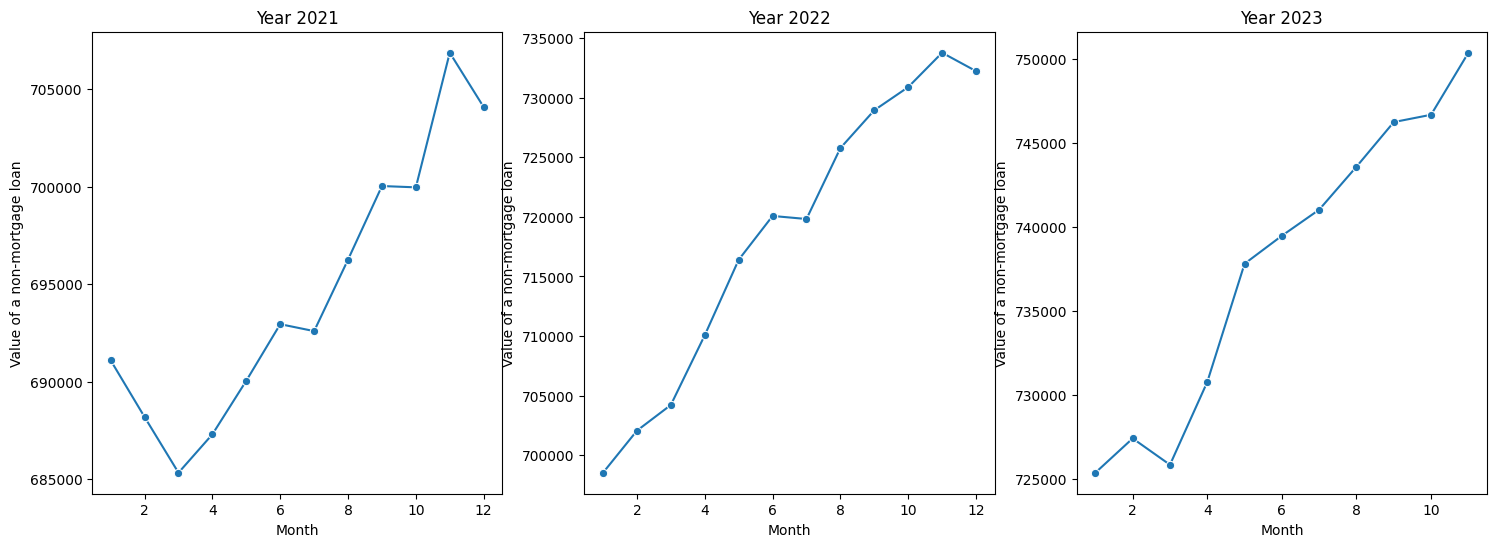

In [8]:
#| label: fig-linearity
#| fig-cap: Line chart by year

plt.figure(figsize=(18, 6))

years = a['year'].unique()
for i, year in enumerate(years, 1):
    plt.subplot(1, len(years), i)
    data_year = a[a['year'] == year]
    sns.lineplot(x='month', y='VALUE', data=data_year, marker='o')
    plt.title(f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Value of a non-mortgage loan')


plt.show()

The charts above (@fig-linearity) provide a more detailed description of this phenomenon. It's worth noting that the data for December 2023 is not included, likely because Statistics Canada hasn't yet finalised the report for that month.

The table below presents the basic descriptive statistics for the dataset by year. As assumed, there is an upward trend with successive months, as evidenced by the increasing average for each year. The standard deviation also follows this pattern, with the value increasing each year. However, there is an exception in 2022, where the standard deviation reaches its maximum value. The interpretation suggests that in 2022, certain domestic or global events may have caused market uncertainty, resulting in the largest deviation from the average value for that year.

In [9]:
grouped_data = a.groupby('year')['VALUE']
mean_values = round(grouped_data.mean(),2)
std_values = round(grouped_data.std(),2)

# Tworzenie tabelki
result_table = pd.DataFrame({
    'Year': mean_values.index,
    'Mean value': mean_values.values,
    'Standard deviation': std_values.values
})
result_table

,Year,Mean value,Standard deviation
0,2021,694562.67,6882.13
1,2022,718558.92,12384.76
2,2023,737666.55,8997.32


## Time series decomposition

Breaking down the series into its individual components - *trend*, *seasonality* and *noise* - will allow for a more detailed exploration of its properties.

In [10]:
b = kredyty_nieh.copy()
b = b.set_index('Date')

Trend plot:

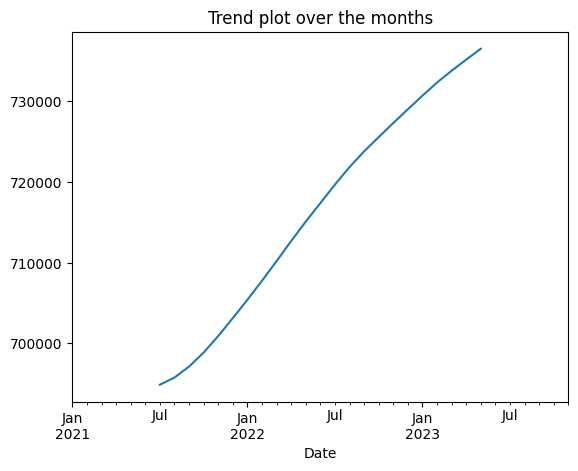

In [11]:
trend_kredyty_nieh = seasonal_decompose(b, period = 12).trend

trend_kredyty_nieh.plot()
plt.title("Trend plot over the months")
plt.show()

There is a clear and significant trend towards an increase in the value of non-mortgage loans held per household over the years.

Seasonality plot:

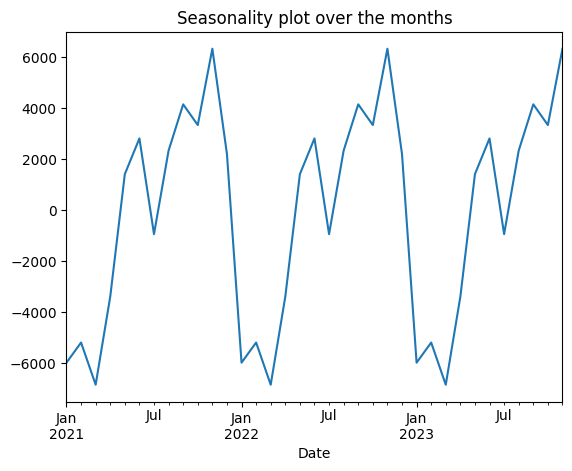

In [12]:
sezon_kredyty_nieh = seasonal_decompose(b, period = 12).seasonal

sezon_kredyty_nieh.plot()
plt.title("Seasonality plot over the months")
plt.show()

The graph above illustrates the annual seasonality of the time series. This indicates that, on a yearly basis, the variables adopt similar values, i.e. consumers in a similar period of a given year behave in a similar way to previous years. Therefore, consumer behaviour is predictable on an annual basis. This information can allow banks to better target their offers to customers depending on the time of year.

Residuals plot:

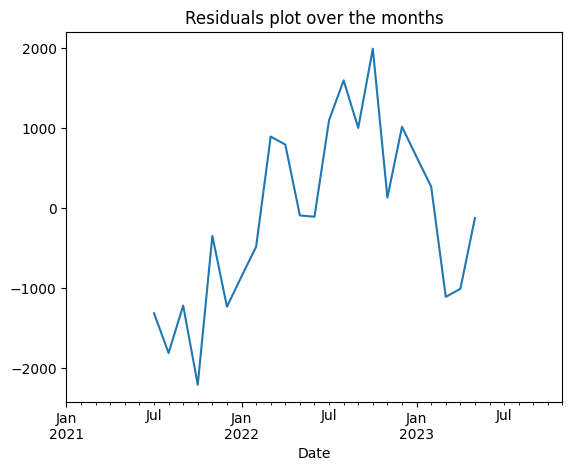

In [13]:
reszty_kredyty_nieh = seasonal_decompose(b, period = 12).resid

reszty_kredyty_nieh.plot()
plt.title("Residuals plot over the months")
plt.show()

Noise is considered as an element that is difficult to predict and control.

## Selecting the initial model

Due to the annual seasonality of the data, we can build a first model - the Holt Winters model.

C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


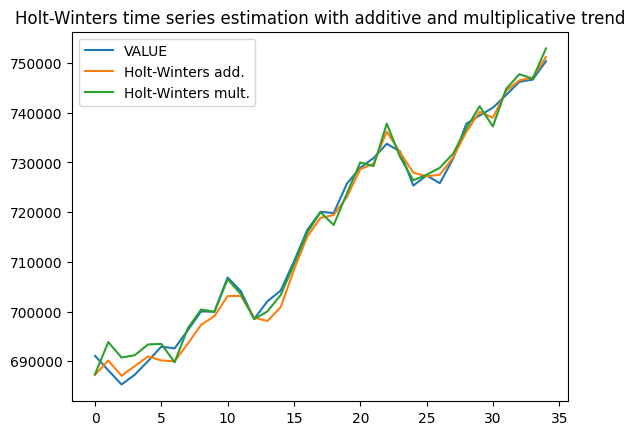

In [14]:
#| label: fig-holt
#| fig-cap: Holt Winters' model

mdl_holt_mul = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='mul', seasonal_periods = 12, seasonal = "mul").fit()
mdl_holt_add = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='add', seasonal_periods = 12, seasonal = "add").fit()

kredyty_nieh['Holt-Winters add.'] = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='add', seasonal_periods = 12, seasonal = "add").fit().fittedvalues
kredyty_nieh['Holt-Winters mult.'] = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='mul', seasonal_periods = 12, seasonal = "mul").fit().fittedvalues
kredyty_nieh[['VALUE','Holt-Winters add.','Holt-Winters mult.']].plot(title="Holt-Winters time series estimation with additive and multiplicative trend")
plt.show()

The graph shows how the Holt-Winters method estimates the analysed series (look @fig-holt). We observe a relatively good fit to the theoretical data.
The graphs for additive and multiplicative trend are slightly different. We choose the better model based on the smaller value of the AIC metric.

AIC index value of the additive model:

In [15]:
round(mdl_holt_add.aic,2)

563.15

AIC index value of the multiplicative model:

In [16]:
round(mdl_holt_mul.aic,2)

574.4

The additive trend model turns out to be slightly better than the multiplicative model based on the AIC matric.

## Residuals analysis

Initially, we perform an autocorrelation analysis on the residuals of the constructed model. the Durbin-Watson test. The resulting test statistic value is:

In [17]:
print("Durbin-Watson Test statistic: "+ str(round(durbin_watson(mdl_holt_add.resid),2)))

Durbin-Watson Test statistic: 1.23


The Durbin-Watson test statistic values range from 0 to 4. If the calculated test statistic value falls outside the interval of 1.5 to 2.5, it indicates significant autocorrelation. Therefore, we conclude that the model residuals are correlated.

We carry out a *Dickey-Fuller* test to examine the stationarity of the time series:

In [18]:
print("Dickey-Fuller Test p-value: "+str(round(adfuller(kredyty_nieh.VALUE)[1],2)))

Dickey-Fuller Test p-value: 0.82


We have no grounds to reject the null hypothesis indicating non-stationarity of the time series -> the time series is non-stationary.

We analyse the normality of the distribution of the model residuals. We perform the *Shapiro-Wilk* test:

In [19]:
print("Shaprio-Wilk Test p-value: "+str(round(scipy.stats.shapiro(mdl_holt_add.resid)[1],2)))

Shaprio-Wilk Test p-value: 0.3


There are no grounds to reject the null hypothesis of normality of the distribution of the model residuals.

We test the homogeneity of the model residuals by performing the *Goldfeld-Quandt* test. First, however, we draw a plot of the normalised residuals of the model against the fitted values, from which we can tentatively infer whether the condition for homogeneity of the variance of the residuals is met.

In [20]:
#kredyty_nieh = kredyty_nieh.set_index(['Date']) 
residuals = mdl_holt_add.resid
std_residuals = residuals / np.std(residuals)

sqrt_std_residuals = np.sqrt(np.abs(std_residuals))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


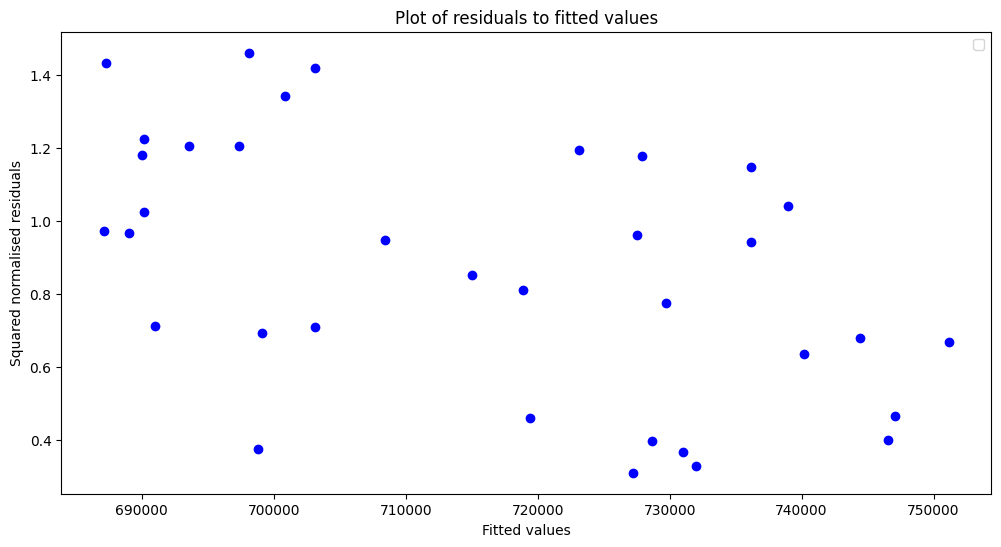

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(mdl_holt_add.fittedvalues, sqrt_std_residuals, marker='o', color='blue')
plt.xlabel('Fitted values')
plt.ylabel('Squared normalised residuals')
plt.title('Plot of residuals to fitted values')

plt.legend()  # Add legend for the zero line
plt.show()

We note that the observations are distributed quite parallel along the X axis (axis of fitted values). We can therefore infer homoskedasticity of the residuals. We will support this thesis by basing our decision on the *p-value* obtained from the previously mentioned test:

In [22]:
mdl_holt_add.model.exog =  np.column_stack((np.ones_like(kredyty_nieh.VALUE), kredyty_nieh.VALUE))

print("Goldfeld-Quandt Test p-value: "+str(round(sms.het_goldfeldquandt(mdl_holt_add.resid, mdl_holt_add.model.exog)[1],2)))

Goldfeld-Quandt Test p-value: 0.83


According to the initial assumption, there are no grounds to reject the hypothesis of homogeneity of the variance of the residuals.

**To sum up.** The model residuals are correlated,time series in non-stationary and shows seasonality throughout the year. 
The appropriate forecasting model will be    **SARIMA*  model*.This model takes seven parameters:w (p,d,q)(P,D,Q)[s].We will use the `auto_arima()` function to estimate these parameters`,which creates different combinations of parameters p,d,q,P,D,Q for a given parameter s, indicating the seasonality period, while minimizing the *AIC* indicator.
Summary of the built model::

In [23]:
model_sarima = auto_arima(kredyty_nieh.VALUE, 
                   seasonal=True, 
                   m=12, 
                   suppress_warnings=True)

model_sarima = model_sarima.fit(kredyty_nieh.VALUE)

In [24]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   35
Model:             SARIMAX(0, 0, 4)x(1, 1, [], 12)   Log Likelihood                -212.959
Date:                             Mon, 04 Mar 2024   AIC                            439.918
Time:                                     22:26:03   BIC                            447.867
Sample:                                          0   HQIC                           441.917
                                              - 35                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.016e+04    570.514     35.329      0.000     1.9e+04    2.13e+04
ma.L1         -0.0105      0.095     -0.110      0.912      -0.198       0.177
ma.L2         -0.0086      0.154     -0.056      0.955      -0.310       0.293
ma.L3         -0.0065      0.170     -0.038      0.970      -0.340       0.327
ma.L4         -0.0088      0.159     -0.055      0.956      -0.320       0.303
ar.S.L12       0.0135      0.003      5.033      0.000       0.008       0.019
sigma2      5.655e+06      0.054   1.05e+08      0.000    5.65e+06    5.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.02   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.00   Prob(JB):                         0.38
Heteroskedasticity (H):               9.42   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+24. Standard errors may be unstable.
"""


Note the *AIC* index value of ~440.

Now we will confront the constructed SARIMA model with theoretical values. We will try to predict how the number of non-mortgage loans per Canadian household will increase/decrease. We anticipate this for the next twenty-four months.

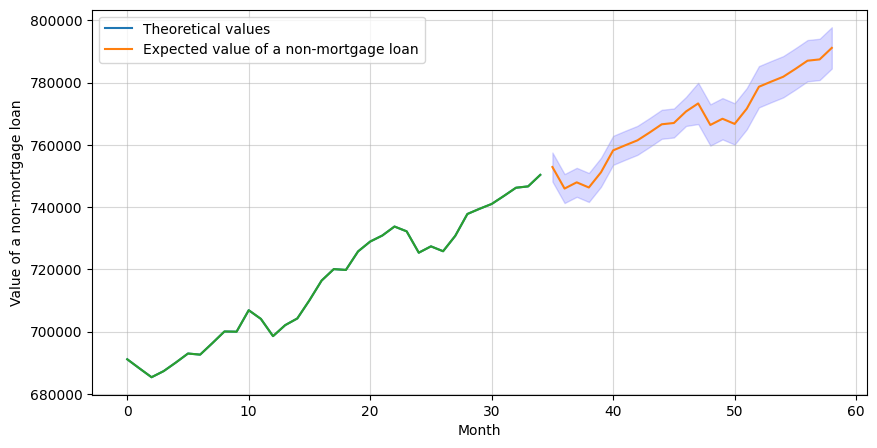

In [25]:
#| label: fig-sarima
#| fig-cap: SARIMA prediction for the next 24 months

forecast_auto, confidence_intervals_auto = model_sarima.predict(n_periods=24,
                                             return_conf_int=True)

ax = kredyty_nieh.VALUE[-12*4:].plot(figsize=(10,5))
forecast_auto.plot(ax=ax)
kredyty_nieh.VALUE.plot(ax=ax)
plt.fill_between(forecast_auto.index, 
                 confidence_intervals_auto[:,[0]].flatten(), 
                 confidence_intervals_auto[:,[1]].flatten(), 
                 color='blue',
                 alpha=0.15)
plt.legend(['Theoretical values',
           'Expected value of a non-mortgage loan'], 
           loc='upper left')
plt.xlabel('Month')
plt.ylabel('Value of a non-mortgage loan')
plt.grid(alpha=0.5)
plt.show()

As you can see in the chart above (@fig-sarima), we note that the upward trend in held non-mortgage loans continues. 
Prediction interval is plotted on the chart.